In [22]:
import esm
from sklearn.manifold import TSNE
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [23]:
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
model.eval()  # Set the model to evaluation mode

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")
print(model)

ProteinBertModel(
  (embed_tokens): Embedding(35, 768, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=True)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (self_attn_layer_norm): ESM1LayerNorm()
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (final_layer_norm): ESM1LayerNorm()
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=72, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): SinusoidalPositionalEmbedding()
)


In [24]:
print(len(alphabet.all_toks[4:25]))
amino_acids = alphabet.all_toks[4:24]
amino_acids_df = pd.DataFrame(amino_acids, columns=["Amino Acid"])
amino_acids_df["property"] = ""
amino_acids_df.set_index("Amino Acid", inplace=True)
amino_acids_df.loc[[ "V", "L", "I", "M","A"], "property"] = "hydrophobic"
amino_acids_df.loc[[ "F", "W", "Y"], "property"] = "aromatic"
amino_acids_df.loc[[ "Q","N","S","T"], "property"] = "polar"
amino_acids_df.loc[[ "C","G","P"], "property"] = "unique"
amino_acids_df.loc[[ "D","E"], "property"] = "negatively charged"
amino_acids_df.loc[[ "K","R", "H"], "property"] = "positively charged"
amino_acids_df.reset_index(inplace=True)
amino_acids_df

property_map = {
    'Hydrophobic': ('green', 'o'),
    'Aromatic': ('green', '+'),
    'Polar': ('blue', 'o'),
    'Unique': ('orange', 'o'),
    'Negatively charged': ('red', 'x'),
    'Positively charged': ('red', 's'),
}
amino_acids_df

21


,Amino Acid,property
0,L,hydrophobic
1,A,hydrophobic
2,G,unique
3,V,hydrophobic
4,S,polar
5,E,negatively charged
6,R,positively charged
7,T,polar
8,I,hydrophobic
9,D,negatively charged


In [25]:
batch_converter = alphabet.get_batch_converter()
data = [(aa, aa) for aa in amino_acids]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

if torch.cuda.is_available():
    batch_tokens = batch_tokens.to(device="cuda")

In [26]:
with torch.no_grad():
    representations = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)['representations'][model.num_layers]
# Extract representations for the amino acids, removing <cls> and <eos> tokens
representations = representations[:, 1, :].detach().cpu().numpy()

In [27]:
representations.shape

(20, 768)

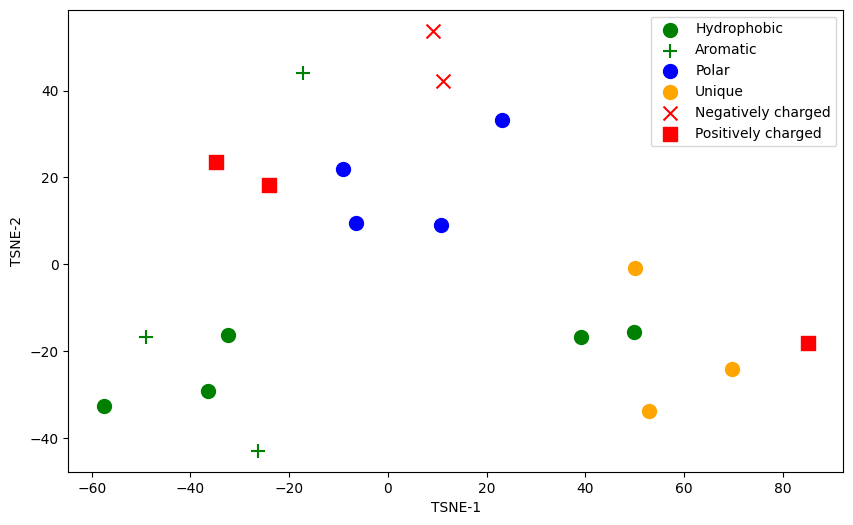

In [28]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb = tsne.fit_transform(representations)
amino_acids_df["TSNE-1"] = emb[:,0]
amino_acids_df["TSNE-2"] = emb[:,1]
amino_acids_df
fig, ax = plt.subplots(figsize=(10, 6))
for property_name, (color, marker) in property_map.items():
    mask = amino_acids_df['property'].str.capitalize() == property_name
    ax.scatter(amino_acids_df[mask]['TSNE-1'], 
               amino_acids_df[mask]['TSNE-2'], 
               c=color, marker=marker, label=property_name, s=100)
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.legend()
plt.show()